In [36]:
import sqlite3
import random
from faker import Faker
import matplotlib.pyplot as plt

In [13]:
faker = Faker('ru-RU')

In [19]:
# tables dictionary structure: 
# {
#   "table_name": [("field", "data type, params")]
# }


class Database:
    def __init__(self, name: str, tables: dict):
        self.conn = sqlite3.connect(f'{name}.db')
        self.cursor = self.conn.cursor()

        self.cursor.execute("PRAGMA foreign_keys = ON")
        self.conn.commit()
        
        
        for table_name, params in tables.items():
            self.create_table(table_name, params)


    def create_table(self, table_name: str, params: list) -> bool:
        fields_string = ""
        
        for field, param in params:
            fields_string += f"{field} {param},"
        
        if fields_string == "":
            return False
        
        fields_string = fields_string[:-1]
        
        try:
            self.cursor.execute(f"CREATE TABLE IF NOT EXISTS {table_name} ({fields_string})")
            self.conn.commit()
            return True
        except Exception as e:
            print("Database (create_table) error:", e)
            return False
        
    
    def execute(self, sql):
        try:
            response = self.cursor.execute(sql)
            self.conn.commit()
            
            return response
        except Exception as e:
            print("Error in sql executing...")
            raise e
    
        
    def __del__(self):
        self.conn.close()
        
            
database = Database("University", {
    "Students": [
        ("id", "INTEGER PRIMARY KEY"),
        ("name", "VARCHAR NOT NULL"),
        ("age", "INTEGER NOT NULL"),
        ("faculty", "VARCHAR NOT NULL")
    ],
    "Grades": [
        ("id", "INTEGER PRIMARY KEY"),
        ("student_id", "INTEGER NOT NULL"),
        ("subject", "VARCHAR NOT NULL"),
        ("grade", "INTEGER NOT NULL"),
        ("FOREIGN KEY(student_id)", "REFERENCES Students(id)")
    ]
})      

In [32]:
def add_students_and_grades(count: int):
    if not isinstance(count, int) or count <= 0:
        print("Incorrect count of people")
        return
        
    for i in range(count):
        name = faker.name()
        age = random.randint(7, 18)
        faculty = random.choice(['Maths&Physics', 'Biology&Science', 'Russian&Literature'])
        database.execute(f"INSERT INTO Students (name, age, faculty) VALUES('{name}', {age}, '{faculty}')")
        
    all_ids = database.execute("SELECT id FROM Students").fetchall()
    
    for id_tuple in all_ids:
        id = int(id_tuple[0])
        student = database.execute(f"SELECT * FROM Students WHERE id = {id}").fetchone()
        
        subject = random.choice(student[3].split("&"))
        grade = random.randint(2, 5)
        
        database.execute(f"INSERT INTO Grades (student_id, subject, grade) VALUES({student[0]}, '{subject}', {grade})")
    
# add_students_and_grades(100)

In [35]:
middle_maths_grade = database.execute("SELECT AVG(grade) FROM Grades WHERE subject = 'Maths'").fetchone()[0]
print("Средняя оценка по математике:", middle_maths_grade)

Средняя оценка по математике: 3.5


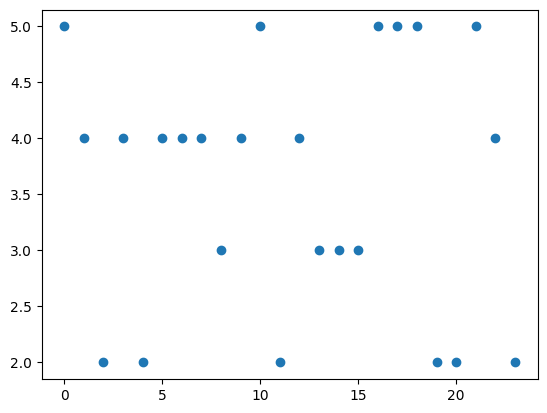

In [68]:
# дополнение лично от меня

def get_grade_graphic(subject: str):
    subject = subject.capitalize()
    
    try:
        data = database.execute(f"SELECT * FROM Grades WHERE subject = '{subject}'").fetchall()
        if not data:
            all_data = database.execute("SELECT subject FROM Grades").fetchall()
            valid_subjects_arr = list(set(all_data))
            valid_subjects = ""
            for i in valid_subjects_arr:
                if i[0] != valid_subjects_arr[-1][0]:
                    valid_subjects += i[0] + ", "
                else:
                    valid_subjects += i[0] + "."
            print("Предмет не найден. Доступные предметы:", valid_subjects)
            return
    except Exception as e:
        print("Что-то пошло не так при поиске вашего предмета.\n", e)
        return 
    
    plt.scatter([i for i in range(len(data))], [grade[3] for grade in data])
    
get_grade_graphic("Russian")